## CAPM Regression of Returns to Find Alpha & Beta ##
 **The Capital Asset Pricing Model (CAPM):**
 
 $$
 \mathbb{E}[R_i] = r_f + \beta_i \big(\mathbb{E}[R_m] - r_f\big)
 $$
 
 - $\mathbb{E}[R_i]$ : Expected return of asset $i$
 - $r_f$ : Risk-free rate   
 - $\beta_i$ : Sensitivity (“beta”) of $i$ to market returns
 - $\mathbb{E}[R_m]$ : Expected market return
 - $\big(\mathbb{E}[R_m] - r_f\big)$ : Market risk premium
 
Goal of this project: Run a regression to see how much of the fund's returns are explained by the market

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [205]:
# Pull historical data from yfinance starting from the year 2000
df = yf.download("ACWI", start="2000-01-01", multi_level_index=False) #MSCI ACWI index
df['market_rets'] = df['Close'].pct_change()
df = df.dropna()
display(df.head())
display(df.tail())

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2008-03-31,35.113640,35.597770,35.113640,35.597770,400,-0.015569
2008-04-01,36.060543,36.060543,35.711684,35.775760,600,0.026967
2008-04-02,36.459240,36.594513,36.345327,36.395164,10700,0.011056
2008-04-03,36.665699,42.503733,36.274124,42.503733,29100,0.005663
2008-04-04,36.644344,39.121949,36.644344,39.121949,9900,-0.000582


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2026-02-04,144.990005,146.250000,144.169998,146.149994,6793500,-0.003779
2026-02-05,143.210007,144.539993,142.919998,143.809998,4062200,-0.012277
2026-02-06,146.279999,146.470001,144.419998,144.460007,4312200,0.021437
2026-02-09,147.410004,147.679993,146.039993,146.279999,3577700,0.007725
2026-02-10,147.309998,148.009995,147.240005,147.820007,6699600,-0.000678


In [206]:
#Get returns data (depends on fund)
fund_data = pd.read_csv("C:/Users/admin/Desktop/Python Projects/parkman-healthcare-partners_returns.csv")
fund_data = fund_data[['Date', 'Return']].dropna() #The column names must be "Date" and "Return" 

# Prepare fund returns
fund_data['Date'] = pd.to_datetime(fund_data['Date'])
fund_data = fund_data.set_index('Date').sort_index()
fund_data['Return'] = fund_data['Return'].str.rstrip('%').astype('float') / 100

fund_data.to_csv('fund_returns.csv')

display(fund_data.head())
display(fund_data.tail())

C:\Users\admin\AppData\Local\Temp\ipykernel_26948\2911737363.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fund_data['Date'] = pd.to_datetime(fund_data['Date'])


,Return
Date,
2019-06-30,0.000085
2019-07-31,-0.015400
2019-08-31,-0.028900
2019-09-30,-0.036700
2019-10-31,0.028000


,Return
Date,
2025-09-30,0.000246
2025-10-31,0.000187
2025-11-30,0.000344
2025-12-31,-0.000088
2026-01-31,-0.000120


In [207]:

#get fund returns and market returns
fund_rets = fund_data['Return']

#Change this depending on the hedge fund returns data frequency
market_rets = df['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1) #monthly
# market_rets = df['market_rets'].resample('D') #daily

market_rets.to_csv('market_returns.csv') #sanity check

# Align series on common dates
rets, market_rets = fund_rets.align(market_rets, join='inner')
rets = rets.dropna()
market_rets = market_rets.dropna()

C:\Users\admin\AppData\Local\Temp\ipykernel_26948\3699652070.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_rets = df['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1) #monthly


### Returns with risk-free rate ###

rf (monthly) = 0.338060%
beta = 0.1486, alpha = 0.001779
mean alpha component = 0.001779
mean beta component  = 0.001253
R^2 = 0.110646


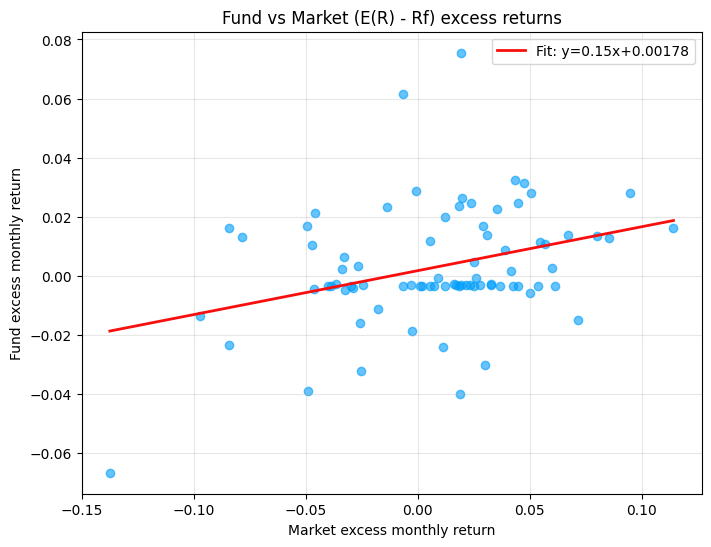

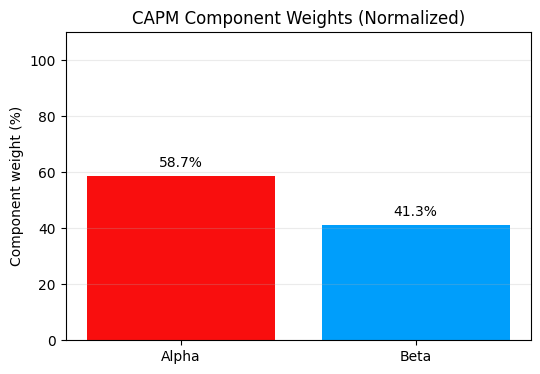

In [ ]:
alpha_color = "#f90e0eff"
beta_color = '#009efb'

#Get 10-year treasury bill data
ten_year_yield = 0.04133

# Single annual risk-free yield (e.g., 10Y). Set this to your value.
rf_yield_annual = ten_year_yield

# Convert annual yield to a constant monthly return (compounded convention)
rf = (1.0 + rf_yield_annual) ** (1.0 / 12.0) - 1.0

market_excess = market_rets - rf
fund_excess = rets - rf

# CAPM regression on excess returns: fund_excess = alpha + beta * market_excess
beta, alpha = np.polyfit(market_excess, fund_excess, 1)

# Mean components (no residual/noise term)
alpha_component = float(alpha)
beta_component = float(beta) * float(market_excess.mean())

print(f'rf (monthly) = {rf * 100 :.6f}%')
print(f'beta = {beta:.4f}, alpha = {alpha:.6f}')
print(f'mean alpha component = {alpha_component:.6f}')
print(f'mean beta component  = {beta_component:.6f}')

# Normalize components (0-100%)
components = [alpha_component, beta_component]
components_nonneg = [max(0.0, float(x)) for x in components]
components_sum = float(sum(components_nonneg))
if components_sum > 0:
    components_pct = [x / components_sum * 100.0 for x in components_nonneg]
else:
    components_pct = [0.0, 0.0]

# Scatter plot to display the fund's return corelation with market
x = market_excess.dropna() # x is a series
y = fund_excess.reindex(x.index).dropna()
x = x.reindex(y.index)

#find r squared for finesse
y_hat = alpha + beta * x
ss_res = ((y - y_hat) ** 2).sum()
ss_tot = ((y - y.mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot
print(f"R^2 = {r2:.6f}")

# Fitted line: y = alpha + beta * x
x_sorted = x.sort_values()
y_fit = alpha + beta * x_sorted

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, color=beta_color)
plt.plot(
    x_sorted,
    y_fit,
    color=alpha_color,
    linewidth=2,
    label=f"Fit: y={beta:.2f}x+{alpha:.5f}",
)
plt.xlabel("Market excess monthly return")
plt.ylabel("Fund excess monthly return")
plt.title("Fund vs Market (E(R) - Rf) excess returns")
plt.grid(True, alpha=0.3)
plt.legend()

ax = plt.gca()

# Same bounds on both axes
lo = float(min(x.min(), y.min()))
hi = float(max(x.max(), y.max()))
pad = (hi - lo) * 0.05 if hi > lo else 0.01
lo -= pad
hi += pad

ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)

# Equal scaling (45° is truly 45°)
ax.set_aspect("equal", adjustable="box")

plt.show()


# Plot normalized alpha and beta (0-100%)

labels = ['Alpha', 'Beta']
colors = [alpha_color, beta_color]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, components_pct, color=colors)
plt.ylabel("Component weight (%)")
plt.title("CAPM Component Weights (Normalized)")
plt.ylim(0, 110)
plt.grid(axis="y", alpha=0.25)
for b in bars:
    h = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        h + 2,
        f"{h:.1f}%",
        ha="center",
        va="bottom",
    )
plt.show()

